# Testing the Model Deployment

After deploying the model using RHODS Model Serving, we'd like to test the model deployment by sending images to the model server for real-time inference.

In this notebook we'll review how to consume the model through the RHODS Model Server.

We'll start by importing the preprocessing and rendering functions that we have worked with in the previous notebook.

In [1]:
import numpy as np

from requests import post
import torch

from classes import classes
from preprocessing import preprocess_image_file
from object_detection import postprocess
from object_rendering import draw_boxes

Let's prepare one of our sample images as a test sample.

In [2]:
image_path = 'sample-images/scene1.jpg'
transformed_image, scaling, padding = preprocess_image_file(image_path)

For testing the model deployment, our test script needs to know the address of the model server. Let's insert the **inference endpoint** that the RHODS Dashboard provides for the deployed model.

In [3]:
prediction_url = 'http://modelmesh-serving.guillaume-demos:8008/v2/models/object-detection/infer'
token = 'none'

We'll now need to package the preprocessed image into a format that the model server can consume. RHODS Model Serving implements a generic prediction interface that allows to query the typical model formats through the HTTP POST method using a JSON request body.

In [4]:
def serialize(image):
    payload = {
        'inputs': [
            {
                'name': 'images',
                'shape': [1, 3, 640, 640],
                'datatype': 'FP32',
                'data': image.flatten().tolist(),
            }
        ]
    }
    return payload

In [5]:
payload = serialize(transformed_image)

Let's now send the serialized cat image to the model server. The inference results will also be returned in a generic JSON structure, which we can unpack straightaway. We'll also apply the post-processing function we defined in the previous notebook to extract the familiar object properties.

In [6]:
def get_model_response(payload, prediction_url, classes_count, token=''):
    headers = {'Authorization': f'Bearer {token}'} if token else {}
    raw_response = post(prediction_url, json=payload, headers=headers)
    try:
        response = raw_response.json()
    except:
        print(f'Failed to deserialize service response.\n'
              f'Status code: {raw_response.status_code}\n'
              f'Response body: {raw_response.text}')
    try:
        model_output = response['outputs']
    except:
        print(f'Failed to extract model output from service response.\n'
              f'Service response: {response}')
    unpacked_output = _unpack(model_output, classes_count)
    return unpacked_output


def _unpack(model_output, classes_count):
    arr = np.array(model_output[0]['data'])
    # Get the response data as a NumPy Array

    output = torch.tensor(arr)  # Create a tensor from array
    prediction_columns_number = 5 + classes_count
    # Model returns model returns [xywh, conf, class0, class1, ...]

    output = output.reshape(
        1,
        int(int(output.shape[0])/prediction_columns_number),
        prediction_columns_number
    )  # Reshape the flat array prediction

    return output

In [7]:
class_labels = classes['computer']
raw_objects = get_model_response(payload, prediction_url, len(class_labels), token=token)
objects = postprocess(raw_objects)
objects

tensor([[468.0357, 369.7310, 534.6882, 414.2020,   0.6067,   1.0000]],
       dtype=torch.float64)

Let's now visualize the result as in the previous notebook.

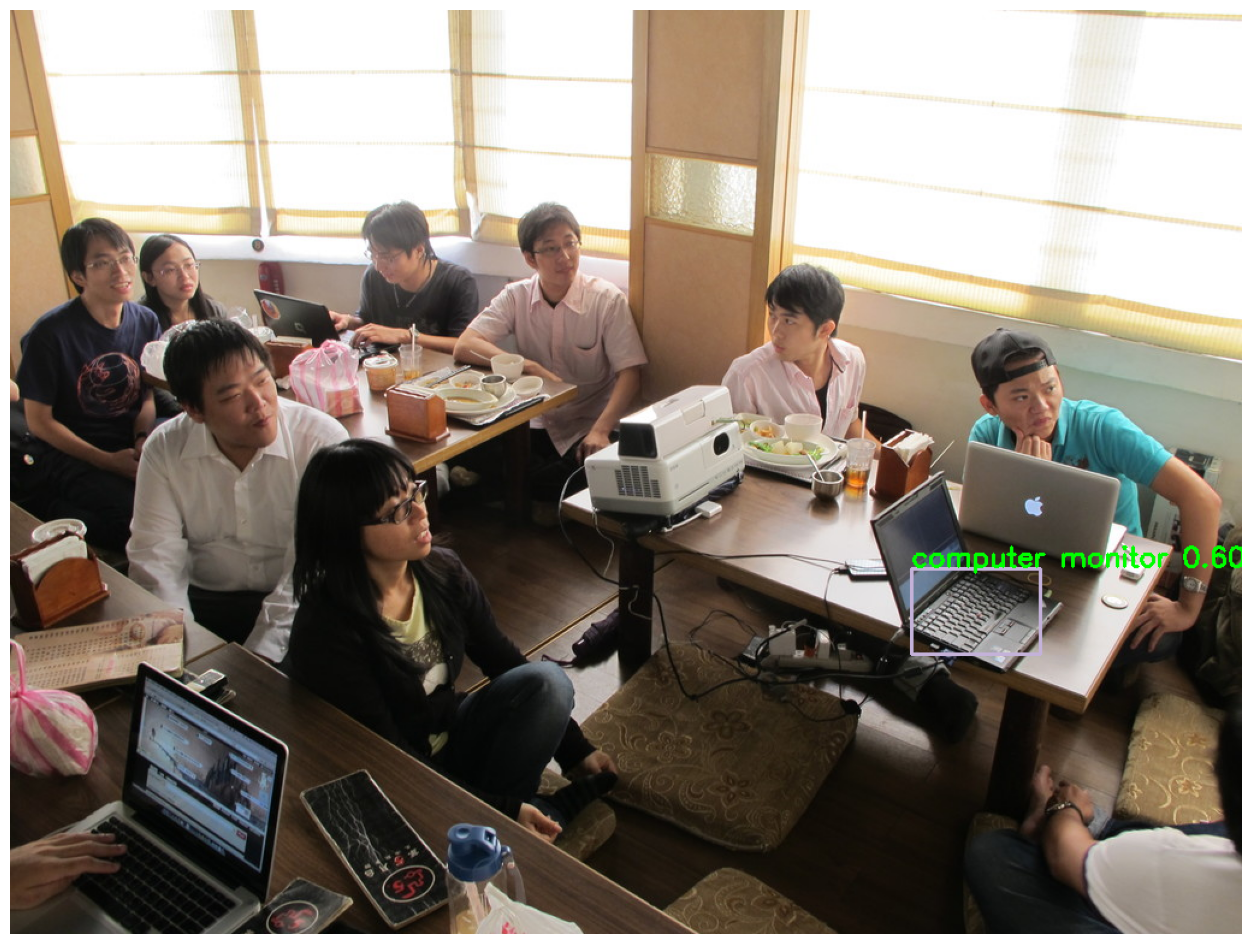

In [8]:
draw_boxes(image_path, objects, scaling, padding, class_labels)

We were able to reproduce the object detection example from the previous notebook, so we can consume the deployed model as expected.

You can now head over to deploying the object detection application to consume this model in a real-time fashion.

After that, we'll explore offline scoring in the next notebook.